In [1]:
import sys
sys.path.append("..")
sys.path.append("../sac_ae")
print(sys.path)

['/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/custom_envs', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/IPython/extensions', '/home/ws/upecj/.ipython', '..', '../sac_ae']


In [2]:
import gym
import custom_robotics
import wrappers
import numpy as np
from collections import namedtuple
import torch
import matplotlib.pyplot as plt

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent

In [4]:
Args = namedtuple("Args", ["env_name", "seed", "pr_files", "env_image_size", "robot_shape", "frame_stack", "agent_image_size", #env
                           "agent", "hidden_dim", "encoder_feature_dim", "actor_log_std_min", "actor_log_std_max", "num_layers", "num_filters", #model
                          "sacae_update_freq", "sacae_encoder_tau", "sacae_autoencoder_lr", "sacae_autoencoder_beta", #sac ae
                          "actor_update_freq", "critic_target_update_freq", "critic_tau", "critic_encoder_tau", "log_interval", "discount", "detach_encoder", #sac
                          "init_temperature", "actor_lr", "actor_beta", "critic_lr", "critic_beta", "alpha_lr", "alpha_beta"]) #sac
args = Args("CustomFetchReachDense-v0", 1, None, 84, 10, 3, 84,
           "sacae", 1024, 50, -10, 2, 4, 32,
           1, 0.05, 1e-5, 0.9,
           2, 2, 0.01, 0.05, 25, 0.99, False,
           0.1, 1e-5, 0.9, 1e-5, 0.9, 1e-4, 0.5)

In [5]:
env = make_envs(args)

In [6]:
action_shape = env.action_space.shape
agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
env_obs_shape = (3*args.frame_stack, args.env_image_size, args.env_image_size)
device = "cpu"

In [7]:
model = make_model(agent_obs_shape, action_shape, args, device)

In [8]:
agent = make_agent(model, device, action_shape, args)

In [9]:
agent.load_model("../sac_ae/log/CustomFetchReachDense-v0-05-30-08-57-im84-b128-s1-sacae/model/250000.pt")

In [10]:
obs = env.reset()

Creating window glfw


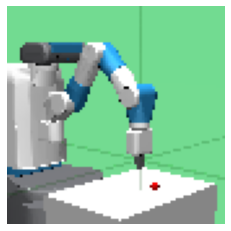

In [11]:
img = obs["image"][:3].transpose(1, 2, 0)
plt.figure()
plt.axis('off')
plt.imshow(img)
plt.savefig('env_original.png')

In [12]:
obs = {
    "image": torch.FloatTensor(obs['image']).to(device).unsqueeze(0),
    "robot": torch.FloatTensor(obs['robot']).to(device).unsqueeze(0)
}

In [19]:
latent = agent.model.autoencoder.encoder(obs["image"])

In [20]:
recreated = agent.model.autoencoder.decoder(latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


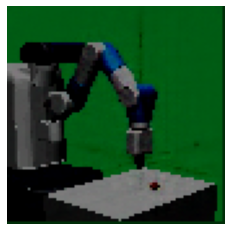

In [21]:
recreated = recreated.detach().numpy()[0, :3].transpose(1, 2, 0)
plt.figure()
plt.axis('off')
plt.imshow(recreated)
plt.savefig('env_recreated.png')